In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Loading the data

In [14]:
mnist = fetch_openml('mnist_784', version = 1, cache = True, as_frame = False)
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [15]:
X_train = X[:10000]
y_train = y[:10000]
X_val = X[10000:12000]
y_val = y[10000:12000]

X_train_test = X[:12000]
y_train_test = y[:12000]
X_test = X[12000:14000]
y_test = y[12000:14000]

In [16]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

# EDA

In [17]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


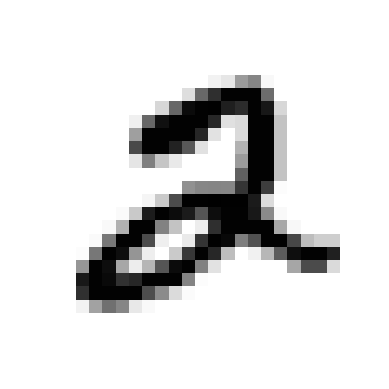

2
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.  13.  25. 100. 122.   7.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  33.
 151. 208. 252. 252. 252. 146.   0.   0.   0.   0.   0.   0.   0.   0.
   0

In [19]:
some_digit = X[5]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

print(y[5])
print(X[5])

In [20]:
print(np.unique(y))

[0 1 2 3 4 5 6 7 8 9]


In [21]:
print(pd.Series(y_train).value_counts().sort_index())

0    1001
1    1127
2     991
3    1032
4     980
5     863
6    1014
7    1070
8     944
9     978
Name: count, dtype: int64


In [22]:
print(pd.DataFrame(X_train).describe())

           0        1        2        3        4        5        6        7    \
count  10000.0  10000.0  10000.0  10000.0  10000.0  10000.0  10000.0  10000.0   
mean       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
std        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
25%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
50%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
75%        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
max        0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

           8        9    ...           774           775           776  \
count  10000.0  10000.0  ...  10000.000000  10000.000000  10000.000000   
mean       0.0      0.0  ...      0.198500      0.101000      0.056700   
std        0.0      0.0  ...      5.933449      

# Data Preparation and modeling

In [23]:
# Standardizing the data
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_val = std_scaler.transform(X_val)
X_train_test= std_scaler.fit_transform(X_train_test)
X_test= std_scaler.transform(X_test)

In [24]:
# SVC
svc = SVC(random_state=42)
param_grid_svc = {
    'C': [0.5, 1, 1.5],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto', 1, 2]
}
grid_svc = GridSearchCV(svc, param_grid=param_grid_svc, cv=3, n_jobs=-1, verbose=2)
grid_svc.fit(X_train, y_train)
y_pred_svc = grid_svc.predict(X_val)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


Validation accuracy: 0.9605
Best parameters: {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}


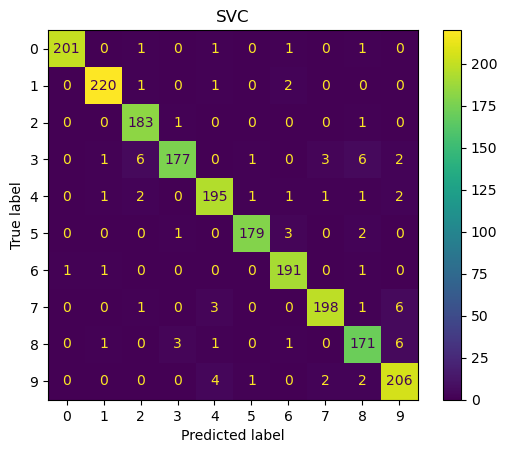

In [103]:
print("Validation accuracy:", accuracy_score(y_val, y_pred_svc))
print("Best parameters:", grid_svc.best_params_)

conf_matrix = confusion_matrix(y_val, y_pred_svc)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.title("SVC")
plt.show()

In [26]:
# Random Forest
rf_clf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30], 
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]  
}
rf_grid = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf, cv=3, n_jobs=-2, verbose=2)
rf_grid.fit(X_train, y_train)
y_pred_rf = rf_grid.predict(X_val)
validation_accuracy = accuracy_score(y_val, y_pred_rf)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


Validation accuracy: 0.9565
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


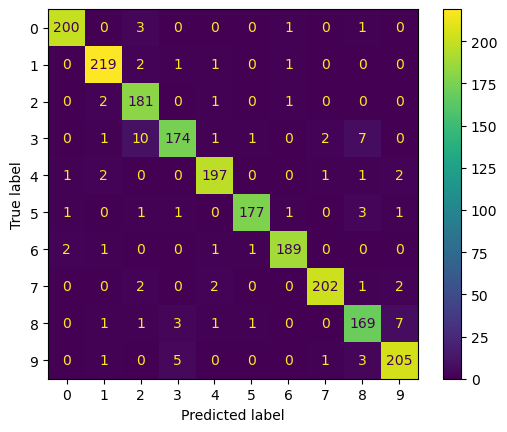

In [104]:
print("Validation accuracy:", validation_accuracy)
print("Best parameters:", rf_grid.best_params_)

conf_matrix = confusion_matrix(y_val, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
#plt.title("Random Forest")
plt.show()

In [32]:
# Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'saga']  
}
grid_lr = GridSearchCV(log_reg, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2)
grid_lr.fit(X_train, y_train)
y_pred_lr = grid_lr.predict(X_val)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


C:\Users\Alia-\anaconda30\envs\python_sthlm\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Validation accuracy: 0.916
Best parameters: {'C': 0.01, 'solver': 'saga'}


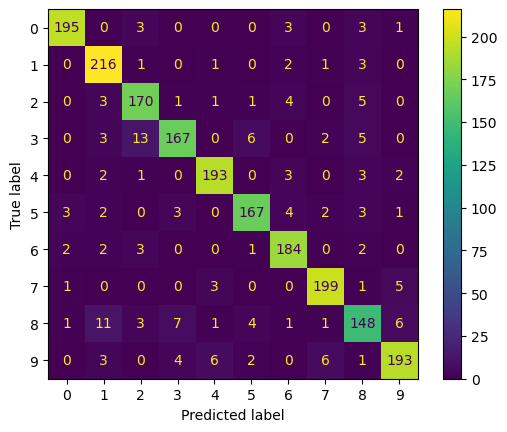

In [105]:
print("Validation accuracy:", accuracy_score(y_val, y_pred_lr))
print("Best parameters:", grid_lr.best_params_)

conf_matrix = confusion_matrix(y_val, y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
#plt.title("Logistic Regression")
plt.show()

# SVC was the best performing model with highest accuracy

In [41]:
param_grid_svc = {
    'C': [0.5, 1, 1.5],
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto', 1, 2]
}
svc = SVC(random_state=42)
grid_svc = GridSearchCV(svc, param_grid=param_grid_svc, cv=3, n_jobs=-1, verbose=2)
grid_svc.fit(X_train_test, y_train_test)

y_test_pred = grid_svc.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


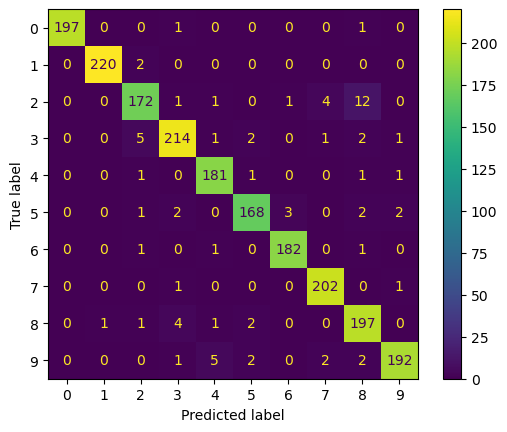

Test accuracy: 0.9625
Best parameters: {'C': 0.5, 'gamma': 1, 'kernel': 'poly'}


In [106]:
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test)
disp_test.plot()
#plt.title("Confusion Matrix - Test Set")
plt.show()

print("Test accuracy:", test_accuracy)
print("Best parameters:", grid_svc.best_params_)